<center><p float="center">
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center> Real-Time Retail Feedback Intelligence
 </center></h1>


### **Business Context**
The client, which is an online retail company, is facing an increase in customer activity during festive seasons and holiday sales. During this time, the company experiences a surge in customer reviews and feedback. They highlight the importance of minimizing the delay in reading and responding to customer feedback, as it can impact their reputation and customer loyalty.

In the document shared with us, the client has provided, along with the business context and objective of the project, a dataset with a sample of customer reviews and feedback. The dataset is stored in a CSV file and contains information such as the review text and the rating given by the customer so we can develop the system that can process thousands of reviews in real-time and provide insights to the company.

### **Objective**
The objective, as expressed in the shared document, is to build a system based on Generative AI prompt engineering to fulfill the client's goals:

* Analyze and categorize sentiment of the reviews.
* Identify the product or service that the review is referring to.
* Summarize different insights by product type and priority.
* Generate automatic and personalized responses to the customers, taking sentiment into account.
* Generate short, actionable reports for the retail teams.

### **Dataset Used for the Notebook**
The dataset consists of a CSV file with the following columns:

* Clothing.ID: The ID of the clothing item being reviewed.
* Age: The age of the customer who wrote the review.
* Title: The title of the review.
* Review.Text: The text of the review.
* Rating: The rating given by the customer to the product, where 1 is the lowest rank and 5 is the highest.
* Recommended.IND: A binary variable indicating whether the customer recommended the product or not.
* Positive.Feedback.Count: The number of positive feedbacks received by the customer review.
* Division.Name: The name of the division where the product is located.
* Department.Name: The name of the department where the product is located.

### **Installing and Importing Necessary Libraries**
First, let's set up the environment by installing the required Python libraries.

In [88]:
# Install the required libraries for the project
!pip install -q numpy pandas matplotlib seaborn wordcloud openai pydantic tqdm plotly

In [2]:
# Import the required libraries for the EDA
import warnings
warnings.filterwarnings("ignore")

# Data processing libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Logging library
from tqdm import tqdm

### **Data Loading**
### Loading and Understanding the Data


In [3]:
from pathlib import Path

# Loading the dataset
print("Loading the dataset...")

filepath = Path("Dataset - Real-Time Retail Feedback Intelligence.csv")
if not filepath.exists():
    raise FileNotFoundError(f"The file {filepath} does not exist.")

# Using sep=None and engine='python' to automatically detect the separator
# and handle potential formatting issues that cause ParserError
df = pd.read_csv(filepath, sep=None, engine='python')
print("Dataset loaded successfully.")

Loading the dataset...
Dataset loaded successfully.


### **Data Overview**

In [4]:
# Displaying the first few rows of the dataset
df.head()

,Unnamed: 0,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name
0,1,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,2,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,3,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,4,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,5,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
# Getting summary of the columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing.ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review.Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended.IND          23486 non-null  int64 
 7   Positive.Feedback.Count  23486 non-null  int64 
 8   Division.Name            23472 non-null  object
 9   Department.Name          23472 non-null  object
 10  Class.Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In the dataset there are 23486 rows and 11 columns.

* The first column is the id of the column, and will be dropped.
* Clothing.ID, Age, Rating and Positive.Feedback.Count are **numeric columns**.
* Title, Review.Text, Division.Name, Department.Name and Class.Name are **object columns**.
* Title, Review.Text, Division.Name, Department.Name and Class.Name have **missing values**.

### **Sanity checks**

In [6]:
# We will drop the Unnamed column
try:
    df = df.drop(columns=['Unnamed: 0'])
except KeyError as err:
    print("The column 'Unnamed: 0' does was already dropped from the DataFrame.")

# We can use change the Clothing.ID to a categorical variable
df['Clothing.ID'] = df['Clothing.ID'].astype(str)

# We will do the same for the Recommended.IND column
df['Recommended.IND'] = df['Recommended.IND'].astype(str)

* The Clothing.ID column, although is numeric, will be considered as a categorical variable for the analysis given that it is a unique identifier for each clothing item and does not make sense to analyze it as a numeric variable. The same will be done for the Recommended.ID column.
* We can see that there is a lot of variability among the Title and Review.Text columns. This is ok, due to the nature of the data, which is introduced by users manually with their own words.

### **Data Cleaning and Preprocessing**

In [7]:
# For training purposes will clone de dataframe ignoring the rows where the columns 'Review.Text', 'Division.Name', 'Department.Name' and 'Class.Name' are empty
df_review = df.copy()
df_review = df_review[df_review['Review.Text'].notna() & df_review['Division.Name'].notna() & df_review['Department.Name'].notna() & df_review['Class.Name'].notna()]

# We will check the info of the dataframe after removing the rows
df_review.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22628 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing.ID              22628 non-null  object
 1   Age                      22628 non-null  int64 
 2   Title                    19662 non-null  object
 3   Review.Text              22628 non-null  object
 4   Rating                   22628 non-null  int64 
 5   Recommended.IND          22628 non-null  object
 6   Positive.Feedback.Count  22628 non-null  int64 
 7   Division.Name            22628 non-null  object
 8   Department.Name          22628 non-null  object
 9   Class.Name               22628 non-null  object
dtypes: int64(3), object(7)
memory usage: 1.9+ MB


For training and test purposes, we will keep the rows that have all the necessary columns to analyze sentiment and correlate the feedback with the product features.

### **Exploratory Data Analysis**

#### Analyzing summary statistics of numeric columns

In [8]:
# Get a quick overview of the numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,23486.0,43.198544,12.279544,18.0,34.0,41.0,52.0,99.0
Rating,23486.0,4.196032,1.110031,1.0,4.0,5.0,5.0,5.0
Positive.Feedback.Count,23486.0,2.535936,5.702202,0.0,0.0,1.0,3.0,122.0


* The minimum age of the customers is 18 years old, while the maximum es 99. The mean is around 43 years, which is very slightly skewed to the right from the median of 41 years.
* Ratings go from 1 to 5 stars, with a mean of 5. The data is skewed to the left.
* The Possitive.Feedback.Count column has a mean of 2.5 and a standard deviation of 5.7, while the mean is 1. The minimum and maximum values are 0 and 122 respectively. The data is skewed to the right.

#### Analyzing summary statistics on categorical columns

In [9]:
# Get values in each categorical column
categorical_columns = ['Clothing.ID', 'Title', 'Review.Text', 'Division.Name', 'Department.Name', 'Class.Name']
for column in categorical_columns:
    print("=" * 50)
    print("\tAnalyzing column:", column)
    print("=" * 50)
    print("\tUnique values:", df[column].nunique())
    print("\tTop 20 values:", df[column].value_counts().head(20))
    print("\tMissing values:", df[column].isnull().sum())
    print("\tData types:", df[column].dtypes)
    print(2 * "\n")

	Analyzing column: Clothing.ID
	Unique values: 1206
	Top 20 values: Clothing.ID
1078    1024
862      806
1094     756
1081     582
872      545
829      527
1110     480
868      430
895      404
936      358
867      351
850      338
1095     327
863      306
1077     297
1059     294
1086     291
1080     289
860      288
1083     249
Name: count, dtype: int64
	Missing values: 0
	Data types: object



	Analyzing column: Title
	Unique values: 13993
	Top 20 values: Title
Love it!            136
Beautiful            95
Love                 88
Love!                84
Beautiful!           72
Beautiful dress      60
Love it              59
Gorgeous             53
Love this dress!     53
Cute top             52
Disappointed         51
Perfect              49
Great dress          49
Super cute           44
Adorable             43
Great top            42
Not for me           37
Runs small           36
Great top!           35
Great dress!         35
Name: count, dtype: int64
	Missing values: 

From the categorical data, we can see that there is a lot of variability among the Title and Review.Text, which requires a more exhaustive analysis. This will be done in the next sections.

We will focus now on the Clothing.ID, Division.Name, Department.Name and Class.Name columns:
* Clothing.ID: There are 1206 types of articles of clothing in the dataset.
* Division.Name: There 3 different divisions, which are General, General Petite and Initmates (Surely a typo of Intimates).
* Department.Name: The reviews are associated to 6 different departments, that are Tops, Dresses, Bottoms, Intimate, Jackets and Trend.
* Class.Name: There are 20 different classes of articles of clothing. These are:
    * Dresses
    * Knits
    * Blouses
    * Sweaters
    * Pants
    * Jeans
    * Fine gauge
    * Skirts
    * Jackets
    * Lounge
    * Swim
    * Outerwear
    * Shorts
    * Sleep
    * Legwear
    * Intimates
    * Layering
    * Trend
    * Casual bottoms
    * Chemises

#### Distribution of ratings

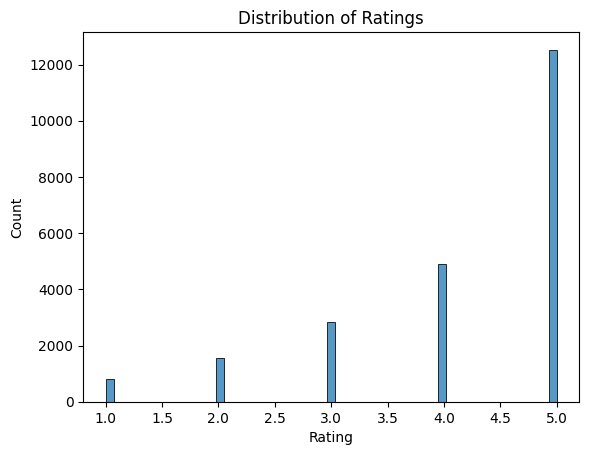

In [10]:
# Plot distribution of ratings
sns.histplot(df_review['Rating'])
plt.title('Distribution of Ratings')
plt.show()

From the reviews distribution, the standard deviation is around 1 which reflects a distribution that is biased to positive reviews, being 5 the most common rating.

#### Distribution of Ratings among Departments

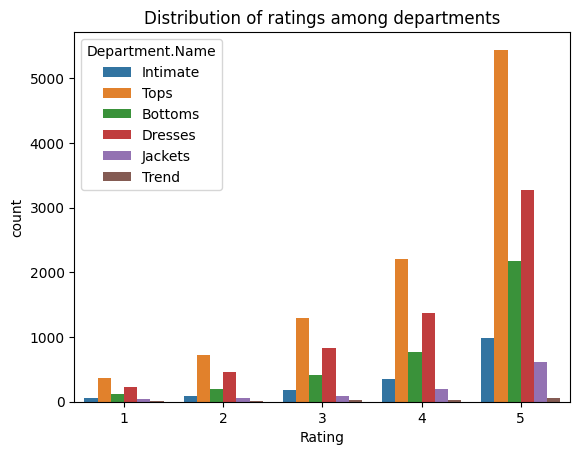

In [11]:
# Checking the distribution of ratings among departments
sns.countplot(data=df_review, x='Rating', hue='Department.Name', )
plt.title('Distribution of ratings among departments')
plt.show()

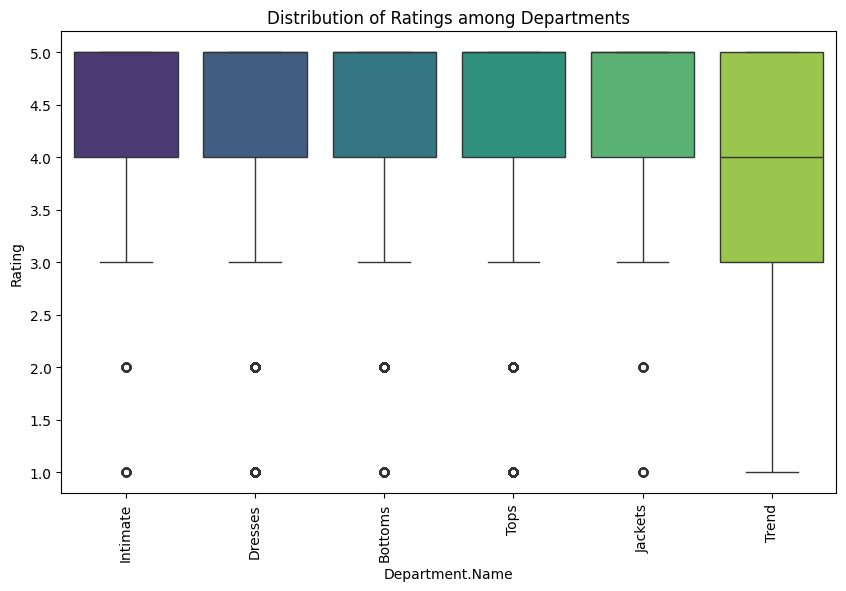

In [12]:
# Usamos boxplot para ver medianas, cuartiles y outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_review, x='Department.Name', y='Rating', palette='viridis')

plt.title('Distribution of Ratings among Departments')
plt.xticks(rotation=90)
plt.show()

The distribution of ratings among departments follows a pattern, where seems to be equally distributed for all the departments, except for the deparment of 'Trend', which has the lowest rating. This could be due to the fact that the amount of activity for this department is too high for the team to handle during these spikes of transactions.

The most rated department is 'Tops', which has the most amount of reviews, although it follows a pattern with the rest of departments along ratings from 1 to 5.

#### Distribution of Common Words in relation with Ratings

Now, we will do a basic analysis on the distribution of words used in the review texts in relation with the rating given by the customers.

In [13]:
# We import the libraries to represent the word distribution in review texts
import re
from wordcloud import WordCloud, STOPWORDS

# We create a set of stopwords to remove common words that do not add value to the word cloud
stopwords = set(STOPWORDS)

In [14]:
# Define a function so we can analyze the word distribution for different ranges of reviews
def plot_word_cloud(text_series, stopwords, title):
    # First we create a text with all the words inside the series
    reviews_text = " ".join(text_series.dropna().astype(str).tolist())

    # Then we remove any special characters and convert the text to lowercase
    reviews_text = re.sub(r"[^a-zA-Z\s]", "", reviews_text)
    reviews_text = reviews_text.lower()

    # Filter out the words that exist inside the stopwords set
    reviews_text = " ".join(word for word in reviews_text.split() if word not in stopwords)

    # Now that the text is cleaned, we can create the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(reviews_text)

    # We can then display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

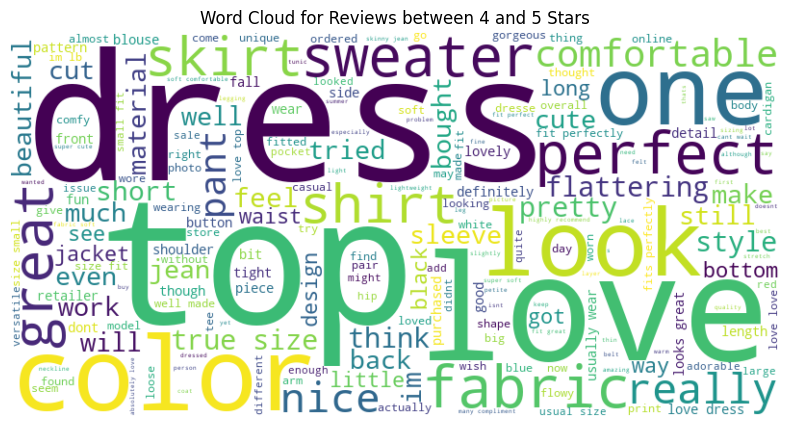

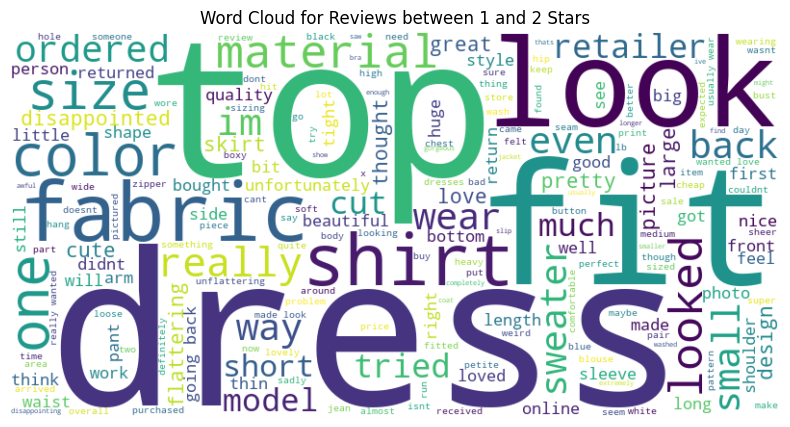

In [15]:
# Analyze word cloud for reviews between 4 and 5 stars
df_review_4_5 = df_review[df_review['Rating'] >= 4]['Review.Text']
plot_word_cloud(df_review_4_5, stopwords, title='Word Cloud for Reviews between 4 and 5 Stars')

# Analyze word cloud for reviews between 1 and 2 stars
df_review_1_2 = df_review[df_review['Rating'] <= 2]['Review.Text']
plot_word_cloud(df_review_1_2, stopwords, title='Word Cloud for Reviews between 1 and 2 Stars')

Se ven muchas referencias a palabras que hacen referencia a prendas. Voy a intentar filtrar por adjetivos y volverlo a intentar. Para ello, utilizaremos la librería 'spacy'

In [16]:
# Install spacy and download the English language model
!pip install spacy
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------------- -------------------- 6.3/12.8 MB 32.2 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 36.4 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 20.6 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [17]:
# Importing the new library spacy
import spacy

# Loading the model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Increasing the max length of the text
nlp.max_length = 6000000

In [18]:
# Define an improved function for ploting a wordcloud only using adjectives
def plot_word_cloud_adjectives(text_series, stopwords, title):
    # Join all the text in the series and remove special characters
    full_text = " ".join(text_series.dropna().astype(str).tolist())
    full_text = re.sub(r"[^a-zA-Z\s]", "", full_text).lower()

    # Process the text with spaCy
    doc = nlp(full_text)

    # Clean the words
    clean_words = [
        token.lemma_ for token in doc 
        if token.pos_ == "ADJ" and token.lemma_ not in stopwords
    ]
    
    final_text = " ".join(clean_words)

    # If there are no adjectives, return
    if not final_text:
        print(f"No se encontraron adjetivos para el título: {title}")
        return

    # Generate the wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(final_text)

    # Plot the wordcloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

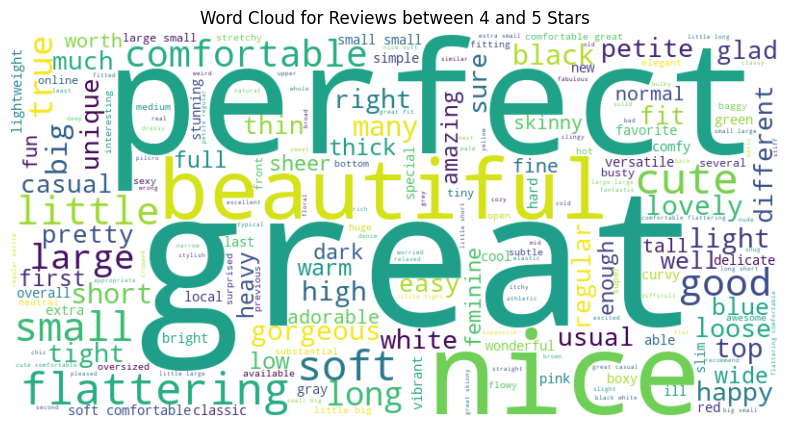

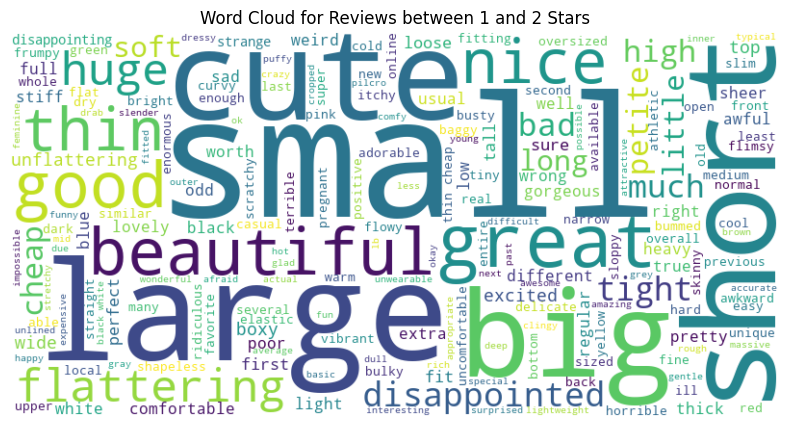

In [19]:
# Analyze word cloud for reviews between 4 and 5 stars
df_review_4_5 = df_review[df_review['Rating'] >= 4]['Review.Text']
plot_word_cloud_adjectives(df_review_4_5, stopwords, title='Word Cloud for Reviews between 4 and 5 Stars')

# Analyze word cloud for reviews between 1 and 2 stars
df_review_1_2 = df_review[df_review['Rating'] <= 2]['Review.Text']
plot_word_cloud_adjectives(df_review_1_2, stopwords, title='Word Cloud for Reviews between 1 and 2 Stars')

For analyzing the most common words in reviews between 4 and 5 and between 1 and 2, we used two approaches: filter words for each range of ratings and filter adjectives for each range of ratings.

Looking at both approaches for generating word clouds, we can see:

* For ratings between 4 and 5: 
    * For the first approach, 'Love' is a word that comes to the eyes. There are also references to clothe types, such as 'dress', 'tops', which do not give insight about the sentiment of the review, but can be helpful for determining the type of product - also we see references about 'color', 'material' and 'fabric'
    * For the second approach we can see 'great', 'beautiful', 'perfect', 'soft', 'comfortable', 'flattering'.

* For ratings between 1 and 2:
    * For the first approach we also see 'dress', 'tops' and other clothing types, and is harder to identify any relation with the sentiment of the review.
    * For the second approach, there are references to the sizes of cloth, like 'small', 'large', 'short', 'big', but also references to words that relate to good sentiments like good, beautiful. There are some evident words that relates to bad reviews like disappointed and scratchy that are mildly visible.


From this preliminar analysis, we can see that there is some ambiguity in most common words if we want to releate them to sentiment. But it can be useful to determine the clothing type and hints on characteristics that are important for the customer.

## **Building the Generative AI Pipeline**

We will now build a system to analyze the reviews. This involves setting up the AI client, designing prompts, generating structured data, and evaluating the results.

#### **Setup AI Client and Data Sample**
    

#### **Note:**

For this project, we will analyze and categorize a sample of **50 customer reviews**. This number is chosen intentionally. Since the API has a **budget limit of $20**, running prompts on very large datasets can quickly exhaust your quota—especially because this exercise may involve **multiple iterations, prompt refinements, and repeated evaluations**.

To avoid unnecessary cost and ensure efficient experimentation, we recommend the following approach:

*   **Use very small samples (5–10 reviews)** during the **initial testing phase** to validate your prompt structure and logic.
    
*   **Scale up to 50 reviews** for the **final evaluation phase**, ensuring you get enough data to compare prompting techniques without draining your budget.
    
*   This strategy helps maintain cost control while still providing meaningful insights across Zero-Shot, Few-Shot, and Chain-of-Thought techniques.
    

If your API quota gets exhausted, you may temporarily switch to another free AI assistant API. However, note that external tools may also have **rate limits** or **token caps**, so you will need to build retry logic and manage throttling within your code.

In [20]:
# Import the necesary libraries to initialize the OpenAI client
import os
import json
from openai import OpenAI

Initialize the LLM Client using a JSON file for storing the API key.

In [21]:
# Load the API key from the JSON file
print("Loading API key from JSON file...")
with open('api_key.json', 'r') as f:
    api_key_file_info = json.load(f)

gl_openai_api_key = api_key_file_info['openai_api_key']
gl_openai_base_url = api_key_file_info['openai_base_url']
gl_openai_model = api_key_file_info['openai_model']

# Initialize the OpenAI client
print("Initializing OpenAI client...")
client = OpenAI(api_key=gl_openai_api_key, base_url=gl_openai_base_url)

print("API key loaded successfully. ")


Loading API key from JSON file...
Initializing OpenAI client...
API key loaded successfully. 


In [22]:
# List the top 5 models
print("List of available models:")
models = client.models.list()
model_ids = [model.id for model in list(models)[:]]

for name in model_ids:
    print(f"- {name}")

List of available models:
- gpt-4-0613
- gpt-4
- gpt-3.5-turbo
- chatgpt-image-latest
- gpt-4o-mini-tts-2025-03-20
- gpt-4o-mini-tts-2025-12-15
- gpt-realtime-mini-2025-12-15
- gpt-audio-mini-2025-12-15
- davinci-002
- babbage-002
- gpt-3.5-turbo-instruct
- gpt-3.5-turbo-instruct-0914
- dall-e-3
- dall-e-2
- gpt-4-1106-preview
- gpt-3.5-turbo-1106
- tts-1-hd
- tts-1-1106
- tts-1-hd-1106
- text-embedding-3-small
- text-embedding-3-large
- gpt-4-0125-preview
- gpt-4-turbo-preview
- gpt-3.5-turbo-0125
- gpt-4-turbo
- gpt-4-turbo-2024-04-09
- gpt-4o
- gpt-4o-2024-05-13
- gpt-4o-mini-2024-07-18
- gpt-4o-mini
- gpt-4o-2024-08-06
- chatgpt-4o-latest
- gpt-4o-audio-preview
- gpt-4o-realtime-preview
- omni-moderation-latest
- omni-moderation-2024-09-26
- gpt-4o-realtime-preview-2024-12-17
- gpt-4o-audio-preview-2024-12-17
- gpt-4o-mini-realtime-preview-2024-12-17
- gpt-4o-mini-audio-preview-2024-12-17
- o1-2024-12-17
- o1
- gpt-4o-mini-realtime-preview
- gpt-4o-mini-audio-preview
- computer-use

From all the models available, we will select gpt-4o-mini.

**Helper functions**

Before going further, we will define some useful functions and structures to test our prompts. The objective is to create at least one function for each of the following tasks:

1. Generate the responses for single rows
2. Evaluate the responses for single rows
3. Generate and evaluate the responses for multiple rows (full flow)

As for best practices, these funtions will try to be sufficiently restrictive in the output format, using pydantic, but also generic so we can use them for the different prompting techniques we will try.

In [23]:
# This library is used to parse the response from OpenAI
from pydantic import BaseModel
from typing import Literal, Optional


# We will use pydantic to define the response format and save us the step of parsing the response
class ReviewAnalysis(BaseModel):
    product_category: Literal["Dresses", "Knits", "Blouses", "Sweaters", "Pants", "Jeans", "Fine gauge", "Skirts", "Jackets", "Lounge", "Swim", "Outerwear", "Shorts", "Sleep", "Legwear", "Intimates", "Layering", "Trend", "Casual bottoms", "Chemises", "Unknown"]
    sentiment: Literal["positive", "negative", "neutral"]
    summary: str
    personalized_message: str
    retail_insight: str


# Define a function to process the review. This function will be used for all prompting techniques
def process_review(openai_client: OpenAI, system_prompt: str, review_text: str, model: str = "gpt-4o-mini", examples: Optional[list] = None, response_format: Optional[BaseModel] = ReviewAnalysis) -> BaseModel:
    """
    Process a review using OpenAI's GPT-4o-mini model. 

    Args:
        openai_client (OpenAI): The OpenAI client.
        system_prompt (str): The system prompt to use for the review.
        review_text (str): The review text to process.
        model (str, optional): The model to use for the review. Defaults to "gpt-4o-mini".
    
    Returns:
        dict: The response from the OpenAI model.
    """

    try:
        messages = [ {"role": "system", "content": system_prompt} ]

        # Preparation for few-shot prompting
        if examples:
            for example in examples:
                messages.append({"role": "user", "content": example["review_text"]})
                messages.append({"role": "assistant", "content": example["analysis"]})

        # Add the review text to the messages
        messages.append({"role": "user", "content": review_text})

        # Parse the response using pydantic
        response = openai_client.beta.chat.completions.parse(
            model=model,
            messages=messages,
            response_format=response_format,
        )
        return response.choices[0].message.parsed
    except Exception as e:
        print(f"Error processing review: {e}")
        return None    


Now we will test the function and structured response with a smoke test prompt.

In [24]:
smoke_test_prompt = "You are a retail expert from customer service"
smoke_test_review = "This shirt is so comfy and soft!"

# After defining the process_review function, we will test it with a simple example
smoke_test = process_review(
    openai_client=client, 
    system_prompt=smoke_test_prompt, 
    review_text=smoke_test_review
)

print(smoke_test)

product_category='Blouses' sentiment='positive' summary='The shirt is noted for its comfort and softness, making it a favorable choice for the wearer.' personalized_message="Thank you for your feedback! We're thrilled to hear that you find your shirt comfortable and soft. We appreciate your support!" retail_insight='Comfort and softness are key selling points for apparel. Highlighting these features in marketing can attract more customers.'


We are also going to define a function to evaluate the model responses. For this, we will use a hybrid evaluation metric, combining category comparison with ground truth values and LLM-as-a-Judge (LLM-Judge) to measure the quality of the responses.

The evaluation parameters for the response will be as follows:

* Category Comparison: We will compare the predicted category with the ground truth category to measure the accuracy of the model. (0.3 points)

* LLM-Judge: We will use the LLM-Judge to measure the quality of the responses. The LLM-Judge will be used to evaluate the responses based on the following criteria: (0.7 points total)

    * Factuality: The response should be verifiable. (0.30 points)
    * Relevance: The response should actually answer the question. (0.20 points)
    * Clarity: The response should be clear and easy to understand. (0.10 points)
    * Efficiency: The response should be concise and provide the necessary information without being too long. (0.10 points)

    

In [25]:
from pydantic import Field, validator

class JudgeEvaluation(BaseModel):
    relevance: float = Field(description="Does the response address the original review? 10 = Perfect, 0 = No relevance", ge=0, le=10)
    factuality: float = Field(description="Is the response verifiable against the original review and context? 10 = Perfect, 0 = No factuality", ge=0, le=10)
    clarity: float = Field(description="Is the response clear and easy to understand? 10 = Perfect, 0 = No clarity", ge=0, le=10)
    structure: float = Field(description="Is the response well-structured? 10 = Perfect, 0 = No structure", ge=0, le=10)
    hallucination_detected: bool = Field(description="Is the model making up information that is not in the original review or context?")
    justification: str = Field(description="Brief justification for the evaluation score. Maximum 2 sentences. Focus on the reason for penalties")
    metadata_mismatch: bool = Field(description="Is the metadata of the response consistent with the original review?")

    @validator("relevance", "factuality", "clarity", "structure")
    def check_score_range(cls, v):
        if v < 0 or v > 10:
            raise ValueError("Score must be between 0 and 10")

        # We will convert the score to a float between 0 and 1
        return v / 10


def get_judge_evaluation(openai_client: OpenAI, original_review: str, true_category: str, response: BaseModel, model: str = "gpt-4o-mini") -> JudgeEvaluation:
    """
    Evaluate the quality of the response generated by the model.

    Args:
        openai_client: OpenAI client instance.
        original_review: Original review text.
        true_category: True category of the review.
        response: BaseModel object containing the response.
        model: Model to use for evaluation.

    Returns:
        JudgeEvaluation: Evaluation object containing the score and justification.
    """
    # Transform the response to a dictionary so the model can read it
    response_dict = response.model_dump()

    # Generate the response
    response = openai_client.beta.chat.completions.parse(
        model=model,
        messages=[
            {"role": "system", 
            # "content": (
            #     "You are an AI quality evaluator basing your criteria on the following: relevance, factuality, clarity and structure."
            #     "Note: If the model analyzed the review category as 'Unknown', it is better than guessing the wrong category (hallucination), but worse than getting it right."
            #     "Evaluate factuality strictly: if the model claims a fact not in the review, score it 0."
            #     "CRITICAL: Sometimes the 'true_category' (metadata) is wrong and contradicts the 'Original review' text. "
            #         "1. If the model picks a category that matches the TEXT but not the 'true_category', DO NOT mark it as hallucination. "
            #         "2. Set 'metadata_mismatch' to True if you see this conflict. "
            #         "3. High factuality means being faithful to the REVIEW TEXT, even if it contradicts the metadata."
            #     )
            "content": (
                "You are a rigorous AI Quality Auditor. Your goal is to evaluate an analysis based on an original review and its metadata."
                "\n\n### HIERARCHY OF TRUTH:"
                "1. THE REVIEW TEXT is the absolute truth. High 'factuality' means sticking ONLY to what the user said."
                "2. THE METADATA (true_category) is a reference. If the text is ambiguous, the metadata is the tie-breaker."
                
                "\n\n### EVALUATION RULES FOR CATEGORY:"
                "- MATCH: Predicted == True Category. (Perfect score)."
                "- UNKNOWN: Predicted is 'Unknown'. Acceptable if the text provides NO clues. Better than a guess, worse than a match."
                "- METADATA MISMATCH: Set to TRUE ONLY if the text EXPLICITLY names a different product (e.g., text says 'boots' but metadata says 'sweaters')."
                "  * IMPORTANT: If the text is vague (e.g., 'it fits well'), DO NOT mark 'metadata_mismatch' even if the model guesses. Trust the metadata in vague cases."
                "- HALLUCINATION: Set to TRUE ONLY if the model invents details NOT present in the text (e.g., claiming it's 'silk' when the text doesn't mention fabric)."
                "  * CRITICAL: A 'metadata_mismatch' is NOT a hallucination if it's supported by the text."
                
                "\n\n### SCORING GUIDELINES:"
                "- Factuality: Score 0 if the model invents features, colors, or materials. If the model corrects a wrong metadata category based on explicit text, keep Factuality high (10)."
                "- Relevance: Does it answer the user's specific sentiment and product mentions?"
                )
            },
            {"role": "user", "content": f"Original review: {original_review}\nTrue category: {true_category}\nReview Analysis: {response_dict}"}
        ],
        response_format=JudgeEvaluation,
        temperature=0,
    )

    # Return the score
    return response.choices[0].message.parsed


def calculate_total_score(judge_evaluation: JudgeEvaluation, true_category: str, response: BaseModel) -> float:
    """
    Evaluate the quality of the response generated by the model.

    Args:
        judge_evaluation: JudgeEvaluation object containing the score and justification.
        true_category: True category of the review.
        response: BaseModel object containing the response.

    Returns:
        float: Total score of the response.
    """
    # Calculating the consistency comparing directly the true category with the predicted category
    if true_category.lower() == response.product_category.lower():
        consistency = 1.
    elif judge_evaluation.metadata_mismatch:
        consistency = 0.9
    elif response.product_category.lower() == "Unknown":
        consistency = 0.5
    else:
        consistency = 0.0

    # Calculate the efficiency of the response, penalizing if the message is too long
    efficiency = 1.0 if len(response.personalized_message) < 100 and len(response.retail_insight) < 100 else 0.4

    # Defining weights for the criteria
    weights = {
        "consistency": 0.3,
        "factuality": 0.3,
        "relevance": 0.2,
        "clarity": 0.1,
        "efficiency": 0.1
    }

    # Calculate the total score
    total_score = (
        weights["consistency"] * consistency +
        weights["factuality"] * judge_evaluation.factuality +
        weights["relevance"] * judge_evaluation.relevance +
        weights["clarity"] * judge_evaluation.clarity +
        weights["efficiency"] * efficiency
    )

    return round(total_score, 4)

Once the judge evaluation is defined, we can test it again the smoke test prompt we defined before:

In [26]:
# Evaluating smoke test result
smoke_test_evaluation = get_judge_evaluation(client, smoke_test_review, "blouses", smoke_test)

In [27]:
print("Judge evaluation: ")
print(smoke_test_evaluation)

Judge evaluation: 
relevance=1.0 factuality=1.0 clarity=1.0 structure=1.0 hallucination_detected=False justification="The analysis accurately reflects the original review's sentiment and product mention, maintaining high factuality and relevance. The structure is clear and well-organized, addressing the review effectively." metadata_mismatch=False


In [28]:
# Calculate smoke test score
smoke_test_score = calculate_total_score(smoke_test_evaluation, "blouses", smoke_test)
print("Smoke test score: ", smoke_test_score)

Smoke test score:  0.94


From the test we could verify that the model is able to generate a response and the judge evaluation is able to evaluate the response with a score that is according to the rules we set. 

**Sample Preparation**

Now that we have defined the basic functions for the model testing, we will prepare a function that randomly selects N reviews, making sure we have a mix of positive and negative reviews and covering different product categories.

In [29]:
def get_balanced_sample(df, n=15, balance_threshold=4):
    """
    Samples reviews from the dataframe until a balanced distribution of ratings is found
    based on the harmonic mean of positive, negative, and neutral counts.
    """
    random_state = 1
    while True:
        df_sample = df.sample(n=n, random_state=random_state)

        # Count frequencies of each rating category
        positive_rating = len(df_sample[df_sample['Rating'] > 3])
        negative_rating = len(df_sample[df_sample['Rating'] < 3])
        neutral_rating = len(df_sample[df_sample['Rating'] == 3])

        # Check for any zero counts to avoid division by zero in harmonic mean
        if positive_rating == 0 or negative_rating == 0 or neutral_rating == 0:
            counts = [0.1, 0.1, 0.1]
        else:
            counts = [positive_rating, negative_rating, neutral_rating]

        # Calculate harmonic mean
        harmonic_mean = len(counts) / sum(1 / count for count in counts)
        
        if harmonic_mean >= balance_threshold:
            return df_sample, random_state
        
        random_state += 1

In [30]:
# Execute the refactored function
df_preliminar_sample, random_state = get_balanced_sample(df_review)

# Print results
print("Random state:", random_state)
print(df_preliminar_sample['Rating'].value_counts())
df_preliminar_sample.head()

Random state: 56
Rating
5    5
2    4
3    3
4    2
1    1
Name: count, dtype: int64


,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name
11998,602,36,Not what i expected,This romper was not what i expected when i ori...,3,0,0,General,Bottoms,Shorts
20437,1081,53,Not what i had hoped for,On a positive note the dress was very well mad...,2,0,1,General,Dresses,Dresses
6827,384,30,Very nice,"I'm not sure what cup size i am, 36b or 36c, b...",5,1,0,Initmates,Intimate,Intimates
19945,514,46,"Cute design, impossible fit",I tried this on in my regular size and was abl...,2,0,9,Initmates,Intimate,Swim
3446,841,35,Not as expected,"In paper crown dresses, i wear a small or size...",2,0,11,General Petite,Tops,Blouses


In [63]:
# Execute the refactored function
df_final_sample, random_state = get_balanced_sample(df_review, n=50, balance_threshold=14)

# Print results
print("Random state:", random_state)
print(df_final_sample['Rating'].value_counts())
df_final_sample.head()

Random state: 1357
Rating
5    22
3    11
2     9
1     4
4     4
Name: count, dtype: int64


,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name
20038,895,36,NaN,"This sweater is so lovely, i bought it first i...",5,1,0,General,Tops,Fine gauge
8486,895,35,Not for me...,"On me, this top is totally frumpy and boxy. i ...",2,0,4,General,Tops,Fine gauge
11067,866,38,Beautiful peplum!,"I absolutely adore peplum tops, although some ...",5,1,9,General,Tops,Knits
14361,935,35,Poor quality,I ordered this cardigan on sale and it was a w...,2,0,0,General,Tops,Sweaters
22463,1131,28,Too large and low quality,I wanted to like this coat so bad! i loved the...,2,0,0,General Petite,Jackets,Outerwear


We implemented a brute force algorithm to find a mildly balanced sample of the dataset, asuming there is a correlation between the rating and the sentiment of the review, resulting in:

* Preliminar sample (df_preliminar_sample) of 15 reviews with 5 'negative' reviews (less than 3), 7 possitives (greater than 3) and 3 neutral reviews (equal to 3).
* Final sample (df_final_sample) of 50 reviews with 13 'negative' reviews (less than 3), 26 possitives (greater than 3) and 11 neutral reviews (equal to 3).

**Result formatting**

At last, we will define a function that let's transform the prompt system results (ReviewAnalysis and Score lists) into a pandas DataFrame.

In [56]:
def results_to_dataframe(analysis_results: list[ReviewAnalysis], scores: list[float], prefix: str) -> pd.DataFrame:
    """
    Converts ReviewAnalysis results and their scores into a DataFrame.
    """
    # 1. Convert Pydantic results to a list of dictionaries
    data = [item.model_dump() for item in analysis_results]
    
    # 2. Create DataFrame
    df_results = pd.DataFrame(data)
    
    # 3. Add the scores column
    df_results['score'] = scores
    
    # 4. Add prefix to column names
    return df_results.add_prefix(prefix)

#### **Prompt Engineering and Evaluation**

We will test three different prompting techniques. For each, we will create a basic version (V1) and an enhanced version (V2).

The steps for designing each prompt system:

1. For each version, we will create an initial prompt that iteratively refines the model responses.

2. These responses will be evaluated by the judge function defined in the previous sections..   

3. For the each version, we will test against 15 balanced random selected reviews. Then we will evaluate a larger set of reviews (50).
    
4. The results for each version is going to be summarized into an average score.

#### **Technique 1: Zero-Shot Prompting**
    

**First version of Zero-shot system**

During this phase we are going to test basic prompts using zero-shot techniques, so we can validate the quality of the responses and select the first version of the system. For this phase we will be using the preliminar dataset which only have 15 reviews.

In [32]:
# We will start with the simplest prompt. The same that we used for the smoke test before
v1_zero_shot_promt = "You are a retail expert from customer service"

# Loop through the 15 reviews and save the results in a list
v1_zero_shot_results = [process_review(openai_client=client, system_prompt=v1_zero_shot_promt, review_text=review) for review in tqdm(df_preliminar_sample['Review.Text'], desc="Processing reviews - Zero-shot V1")]


Processing reviews - Zero-shot V1: 100%|██████████| 15/15 [00:40<00:00,  2.68s/it]


In [33]:
print("Zero-shot V1 results: ")
print(v1_zero_shot_results)

Zero-shot V1 results: 
[ReviewAnalysis(product_category='Unknown', sentiment='negative', summary='The romper was too casual for the occasion and had quality issues with a button falling off upon arrival.', personalized_message="We're sorry to hear that the romper did not meet your expectations, and we appreciate your feedback about the quality issue. We hope you find something more suitable for your occasion!", retail_insight="It's important to ensure product descriptions and images accurately reflect the style of the item to avoid customer dissatisfaction, particularly for special occasions."), ReviewAnalysis(product_category='Dresses', sentiment='negative', summary='The dress was well made with great quality, but the style and color were unflattering.', personalized_message='Thank you for your feedback! We appreciate you sharing your experience with the dress. We’re sorry to hear that the fit and color did not meet your expectations.', retail_insight='Customers often value quality in

In [34]:
# Evaluate the results
v1_zero_shotllm_judge_results = [get_judge_evaluation(openai_client=client, original_review=df_preliminar_sample.iloc[idx]['Review.Text'], true_category=df_preliminar_sample.iloc[idx]['Class.Name'], response=result) for idx, result in tqdm(enumerate(v1_zero_shot_results), desc="Judging zero-shot V1 results")]

Judging zero-shot V1 results: 15it [00:29,  1.98s/it]


In [35]:
print("Zero-shot V1 evaluation results:")
print(v1_zero_shotllm_judge_results)

Zero-shot V1 evaluation results:
[JudgeEvaluation(relevance=1.0, factuality=1.0, clarity=1.0, structure=1.0, hallucination_detected=False, justification="The analysis accurately reflects the review's sentiment and details, addressing the quality issue and the casual nature of the romper. It is well-structured and clear, providing a relevant response to the user's experience.", metadata_mismatch=True), JudgeEvaluation(relevance=1.0, factuality=1.0, clarity=1.0, structure=1.0, hallucination_detected=False, justification="The analysis accurately reflects the original review's sentiment and details about the dress, including its quality and unflattering appearance. It maintains clarity and structure while addressing the user's experience effectively.", metadata_mismatch=False), JudgeEvaluation(relevance=1.0, factuality=1.0, clarity=1.0, structure=1.0, hallucination_detected=False, justification="The analysis accurately reflects the original review's sentiments and details about the product

In [36]:
# Calculate scores for preliminar samples
v1_zero_shot_scores = [calculate_total_score(v1_zero_shotllm_judge_results[idx], df_preliminar_sample.iloc[idx]['Class.Name'], result) for idx, result in tqdm(enumerate(v1_zero_shot_results), desc="Zero-shot V1 scores")]

for idx, score in enumerate(v1_zero_shot_scores):
    print(idx, score)

print("\n")
print(np.mean(v1_zero_shot_scores))

Zero-shot V1 scores: 15it [00:00, 7507.70it/s]

0 0.91
1 0.94
2 0.94
3 0.94
4 0.59
5 0.64
6 0.94
7 0.61
8 0.94
9 0.61
10 0.61
11 0.94
12 0.64
13 0.94
14 0.61


0.7866666666666665


In [37]:
s_idx = 4

print("Original review:")
print(df_preliminar_sample.iloc[s_idx])
print(df_preliminar_sample.iloc[s_idx]['Review.Text'])

print("\n")
print("Zero-shot results:")
print(v1_zero_shot_results[s_idx])

print("\n")
print("Zero-shot judgeresults:")
print(v1_zero_shotllm_judge_results[s_idx])

print("\n")
print("Zero-shot scores:")
print(v1_zero_shot_scores[s_idx])

Original review:
Clothing.ID                                                              841
Age                                                                       35
Title                                                        Not as expected
Review.Text                In paper crown dresses, i wear a small or size...
Rating                                                                     2
Recommended.IND                                                            0
Positive.Feedback.Count                                                   11
Division.Name                                                 General Petite
Department.Name                                                         Tops
Class.Name                                                           Blouses
Name: 3446, dtype: object
In paper crown dresses, i wear a small or size 6, so for this top, i ordered a small. it was huge on me! for reference, i'm 5'7", 130 lbs, 34a. it is very wide towards the bottom, and it 

After tuning the system and fixing the errors during this preliminar analysis, we can move on to apply the system to a larger scale and determine it's score.

In [38]:
# Apply analysis and evaluation to 100 reviews, and save the avg result.
v1_zero_shot_final_results = [process_review(client, v1_zero_shot_promt, review_text) for review_text in tqdm(df_final_sample['Review.Text'], desc='V1 Zero-Shot - Processing reviews...')]

# Evaluate the responses
v1_zero_shot_llm_judge_final_results = [get_judge_evaluation(openai_client=client, original_review=df_final_sample.iloc[idx]['Review.Text'], true_category=df_final_sample.iloc[idx]['Class.Name'], response=result) for idx, result in tqdm(enumerate(v1_zero_shot_final_results), desc="Judging zero-shot V1 final results")]

# Calculate scores for final sample
v1_zero_shot_final_scores = [calculate_total_score(v1_zero_shot_llm_judge_final_results[idx], df_final_sample.iloc[idx]['Class.Name'], result) for idx, result in tqdm(enumerate(v1_zero_shot_final_results), desc="Zero-shot V1 final scores")]

# Calculate the average score
v1_zero_shot_avg_final_score = np.mean(v1_zero_shot_final_scores)


# Print the average score
print(f"Average score for zero-shot V1: {v1_zero_shot_avg_final_score}")


V1 Zero-Shot - Processing reviews...: 100%|██████████| 50/50 [02:13<00:00,  2.68s/it]
Judging zero-shot V1 final results: 50it [01:52,  2.24s/it]
Zero-shot V1 final scores: 50it [00:00, 5562.88it/s]

Average score for zero-shot V1: 0.7953999999999999


**Second version of Zero-Shot system**

Now that we have a working Zero-Shot system, we can start to build an enhanced version of it. For this, we will:

1. Add some guardrails to the system to make it more factual and robust.
2. Add some context about the company and tone of the response.
3. Give special attention to the accuracy of the system.

Here we start with a preliminar testing, using the same 15 reviews that we used for the first version of the zero-shot prompt system.

In [39]:
# Define the v2 zero_shot prompt that uses company context, tone and encourage factuality in the response
v2_zero_shot_prompt = """
You are an expert analyst for the retail company 'ChicStyle' which has a growing fashion retail platform.

Your tone must be luxurious, sophisticated and relatable to the customer.

Analyze the customer review following the specified output format.

In case the customer review does not specifya product category, you must return 'Unknown' as product category.

"""

# Execute analysis for the 15 preliminar reviews
v2_zero_shot_results = [process_review(openai_client=client, system_prompt=v2_zero_shot_prompt, review_text=review) for review in tqdm(df_preliminar_sample['Review.Text'], desc="Processing reviews - Zero-shot V2")]

Processing reviews - Zero-shot V2: 100%|██████████| 15/15 [00:40<00:00,  2.69s/it]


In [40]:
print("V2 Zero-Shot results:")
print(v2_zero_shot_results)

V2 Zero-Shot results:
[ReviewAnalysis(product_category='Unknown', sentiment='negative', summary='The customer found the romper to be too casual than anticipated and experienced a button malfunction upon unboxing, leading to a decision to return the item despite it looking good on them.', personalized_message="We appreciate your feedback and are sorry to hear that the romper didn't meet your expectations. We strive for excellence in both style and quality, and your experience is valuable in helping us improve.", retail_insight='Customers may desire more detailed descriptors of product styles to align better with occasion-specific expectations, which could enhance satisfaction and reduce return rates.'), ReviewAnalysis(product_category='Dresses', sentiment='negative', summary='The customer appreciated the quality of the dress but found the design unflattering and the color drab, resulting in a return.', personalized_message="We're delighted to hear you appreciated the quality of the dres

In [41]:
# Evaluate the results
v2_zero_shotllm_judge_results = [get_judge_evaluation(openai_client=client, original_review=df_preliminar_sample.iloc[idx]['Review.Text'], true_category=df_preliminar_sample.iloc[idx]['Class.Name'], response=result) for idx, result in tqdm(enumerate(v2_zero_shot_results), desc="Judging zero-shot V2 results")]

Judging zero-shot V2 results: 15it [00:33,  2.24s/it]


In [42]:
print("V2 Zero-Shot evaluation:")
print(v2_zero_shotllm_judge_results)

V2 Zero-Shot evaluation:
[JudgeEvaluation(relevance=1.0, factuality=1.0, clarity=1.0, structure=1.0, hallucination_detected=False, justification="The analysis accurately reflects the review's content, addressing the customer's disappointment with the romper's casual appearance and the button issue. It also maintains clarity and structure while providing relevant insights.", metadata_mismatch=True), JudgeEvaluation(relevance=1.0, factuality=1.0, clarity=1.0, structure=1.0, hallucination_detected=False, justification="The analysis accurately reflects the original review's sentiment and details, maintaining high factuality by not introducing any new information. It is well-structured and clear, addressing the customer's feedback effectively.", metadata_mismatch=False), JudgeEvaluation(relevance=1.0, factuality=1.0, clarity=1.0, structure=1.0, hallucination_detected=False, justification="The analysis accurately reflects the original review's sentiments and details about the fit and materia

In [43]:
# Calculate scores for preliminar sample
v2_zero_shot_scores = [calculate_total_score(v2_zero_shotllm_judge_results[idx], df_preliminar_sample.iloc[idx]['Class.Name'], result) for idx, result in tqdm(enumerate(v2_zero_shot_results), desc="Zero-shot V2 scores")]

for idx, score in enumerate(v2_zero_shot_scores):
    print(idx, score)

print("\n")
print(np.mean(v2_zero_shot_scores))

Zero-shot V2 scores: 15it [00:00, 7492.50it/s]

0 0.91
1 0.94
2 0.94
3 0.94
4 0.59
5 0.64
6 0.94
7 0.85
8 0.91
9 0.91
10 0.61
11 0.94
12 0.64
13 0.94
14 0.64


0.8226666666666667


Let's analyze the element 4 that was the lowest ranked in the previous version of the model.

In [44]:
s_idx = 4

print("Original review:")
print(df_preliminar_sample.iloc[s_idx])
print(df_preliminar_sample.iloc[s_idx]['Review.Text'])

print("\n")
print("Zero-shot results:")
print(v2_zero_shot_results[s_idx])

print("\n")
print("Zero-shot judgeresults:")
print(v2_zero_shotllm_judge_results[s_idx])

print("\n")
print("Zero-shot scores:")
print(v2_zero_shot_scores[s_idx])

Original review:
Clothing.ID                                                              841
Age                                                                       35
Title                                                        Not as expected
Review.Text                In paper crown dresses, i wear a small or size...
Rating                                                                     2
Recommended.IND                                                            0
Positive.Feedback.Count                                                   11
Division.Name                                                 General Petite
Department.Name                                                         Tops
Class.Name                                                           Blouses
Name: 3446, dtype: object
In paper crown dresses, i wear a small or size 6, so for this top, i ordered a small. it was huge on me! for reference, i'm 5'7", 130 lbs, 34a. it is very wide towards the bottom, and it 

After setting up the second version of the zero-shot review analyzer, we will execute it on a larger dataset to evaluate its performance and compare it with the other version and prompting techniques.

In [45]:
# Apply analysis and evaluation to 100 reviews, and save the avg result.
v2_zero_shot_final_results = [process_review(client, v2_zero_shot_prompt, review_text) for review_text in tqdm(df_final_sample['Review.Text'], desc='V2 Zero-Shot - Processing reviews...')]

# Evaluate the responses
v2_zero_shot_llm_judge_final_results = [get_judge_evaluation(openai_client=client, original_review=df_final_sample.iloc[idx]['Review.Text'], true_category=df_final_sample.iloc[idx]['Class.Name'], response=result) for idx, result in tqdm(enumerate(v2_zero_shot_final_results), desc="Judging zero-shot V2 final results")]

# Calculate scores for final sample
v2_zero_shot_final_scores = [calculate_total_score(v2_zero_shot_llm_judge_final_results[idx], df_final_sample.iloc[idx]['Class.Name'], result) for idx, result in tqdm(enumerate(v2_zero_shot_final_results), desc="Zero-shot V2 final scores")]

# Calculate the average score
v2_zero_shot_avg_final_score = np.mean(v2_zero_shot_final_scores)


# Print the average score
print(f"Average score for zero-shot V2: {v2_zero_shot_avg_final_score}")

V2 Zero-Shot - Processing reviews...: 100%|██████████| 50/50 [02:30<00:00,  3.01s/it]
Judging zero-shot V2 final results: 50it [01:43,  2.08s/it]
Zero-shot V2 final scores: 50it [00:00, 7144.59it/s]

Average score for zero-shot V2: 0.7997999999999998


**Save V1 and V2 Zero-Shot results into a DF**

In [64]:
# Save final results into a data frame
df_v1_zs = results_to_dataframe(v1_zero_shot_final_results, v1_zero_shot_final_scores, "V1_Zero_Shot_")
df_v2_zs = results_to_dataframe(v2_zero_shot_final_results, v2_zero_shot_final_scores, "V2_Zero_Shot_")
df_zero_shot_comparison = pd.concat([df_v1_zs, df_v2_zs], axis=1)

# Making sure to reset indices to avoid mismatch
df_zero_shot_comparison.reset_index(drop=True, inplace=True)
df_final_sample.reset_index(drop=True, inplace=True)

# Save final results into the final sample dataframe
df_final_sample = pd.concat([df_final_sample, df_zero_shot_comparison], axis=1)
df_final_sample.head()

,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name,...,V1_Zero_Shot_summary,V1_Zero_Shot_personalized_message,V1_Zero_Shot_retail_insight,V1_Zero_Shot_score,V2_Zero_Shot_product_category,V2_Zero_Shot_sentiment,V2_Zero_Shot_summary,V2_Zero_Shot_personalized_message,V2_Zero_Shot_retail_insight,V2_Zero_Shot_score
0,895,36,NaN,"This sweater is so lovely, i bought it first i...",5,1,0,General,Tops,Fine gauge,...,"Customer loves the sweater for its comfort, so...",Thank you for your wonderful review! We're thr...,Customers are likely to return for multiple pu...,0.64,Sweaters,positive,The customer adores the sweater for its softne...,"Dear ChicStyle connoisseur, thank you for your...","The positive sentiment towards the softness, c...",0.64
1,895,35,Not for me...,"On me, this top is totally frumpy and boxy. i ...",2,0,4,General,Tops,Fine gauge,...,The customer found the top to be frumpy and bo...,Thank you for your feedback! We’re sorry to he...,Consider offering a tailored fit option for st...,0.64,Blouses,negative,The reviewer found the top to be unflattering ...,We truly appreciate your feedback and apologiz...,Understanding fit preferences is crucial; styl...,0.64
2,866,38,Beautiful peplum!,"I absolutely adore peplum tops, although some ...",5,1,9,General,Tops,Knits,...,Customer loves the design and fit of the peplu...,Thank you for your feedback! We're thrilled to...,Highlighting the versatility and comfort of th...,0.85,Blouses,positive,The customer is enamoured with the peplum top'...,We're thrilled to hear that you adore our pepl...,The customer's experience indicates a strong p...,0.61
3,935,35,Poor quality,I ordered this cardigan on sale and it was a w...,2,0,0,General,Tops,Sweaters,...,The customer loved the fit and design of the c...,We're sorry to hear about your experience with...,Quality issues can severely affect customer sa...,0.94,Sweaters,negative,Customer appreciated the fit and color of the ...,We truly appreciate your feedback on the cardi...,Quality control is crucial in maintaining cust...,0.94
4,1131,28,Too large and low quality,I wanted to like this coat so bad! i loved the...,2,0,0,General Petite,Jackets,Outerwear,...,The customer was disappointed with the coat's ...,We're sorry to hear that the coat didn't meet ...,Quality and sizing issues are critical in oute...,0.94,Outerwear,negative,The customer was enthusiastic about the coat's...,We appreciate your feedback and are sorry to h...,Attention to detail in product quality and acc...,0.94


#### **Technique 2: Few-Shot Prompting**

For this approach, we will start with a simple prompt, with 3 basic examples representing positive, negative and neutral reviews.

Then we will refine the first model adding guardrails and rules to guide the model's response against ambiguous and contradictory reviews.

**First Version of Few-Shot Prompting System**

Reusing the same functions defined before, let's start testing for the v1 few-shot prompting system

In [46]:
# We will keep the prompt simple and focused on the task
v1_few_shot_prompt = "You are a retail expert from customer service"

# Define some basic examples that represent positive, negative, and neutral feedback
v1_few_shot_examples = [
    {
        "review_text": "I love these jeans, they fit perfectly!",
        "analysis": '{"product_category": "Jeans", "sentiment": "positive", "summary": "Perfect fit", "personalized_message": "Glad you loved the fit!", "retail_insight": "Sizing is accurate"}'
    },
    {
        "review_text": "The blouse was missing a button.",
        "analysis": '{"product_category": "Blouses", "sentiment": "negative", "summary": "Missing button", "personalized_message": "We apologize for the quality issue.", "retail_insight": "Check QC in blouses"}'
    },
    {
        "review_text": "The delivery took two weeks. The pants are fine, they fit as expected, but nothing special about the fabric.",
        "analysis": '{"product_category": "Pants", "sentiment": "neutral", "summary": "Fit is okay, but delivery was slow and fabric is average.", "personalized_message": "Thank you for your feedback. We are glad the fit worked out, and we will work on our delivery times.", "retail_insight": "Standard product performance, logistics needs review."}'
    }
]

In [47]:
# Process preliminar samples with the v1 few shot prompt
v1_few_shot_results = [process_review(openai_client=client, system_prompt=v1_few_shot_prompt, review_text=review_text, examples=v1_few_shot_examples) for review_text in tqdm(df_preliminar_sample['Review.Text'])]

100%|██████████| 15/15 [00:26<00:00,  1.74s/it]


In [48]:
# Evaluate the v1 few-shot preliminar results
v1_few_shot_judge_results = [get_judge_evaluation(openai_client=client, original_review=df_preliminar_sample.iloc[idx]['Review.Text'], true_category=df_preliminar_sample.iloc[idx]['Class.Name'], response=result) for idx, result in tqdm(enumerate(v1_few_shot_results), desc="Judging few-shot V1 preliminar results")]

Judging few-shot V1 preliminar results: 15it [00:30,  2.05s/it]


In [49]:
print(v1_few_shot_judge_results)

[JudgeEvaluation(relevance=1.0, factuality=0.8, clarity=1.0, structure=0.9, hallucination_detected=False, justification="The analysis accurately reflects the review's sentiment and main points, but it incorrectly categorizes the product as 'Unknown' instead of 'Shorts', leading to a slight deduction in factuality. Overall, the response is clear and well-structured, addressing the user's concerns effectively.", metadata_mismatch=True), JudgeEvaluation(relevance=1.0, factuality=1.0, clarity=1.0, structure=1.0, hallucination_detected=False, justification="The analysis accurately reflects the original review's sentiment and details about the dress, maintaining high factuality. It is well-structured and clear, addressing the user's feedback effectively.", metadata_mismatch=False), JudgeEvaluation(relevance=1.0, factuality=1.0, clarity=1.0, structure=1.0, hallucination_detected=False, justification="The analysis accurately reflects the original review's sentiment and details about fit and ma

In [50]:
# Calculate scores for final sample
v1_few_shot_scores = [calculate_total_score(v1_few_shot_judge_results[idx], df_preliminar_sample.iloc[idx]['Class.Name'], result) for idx, result in tqdm(enumerate(v1_few_shot_results), desc="Few-Shot V1 preliminar scores")]

for idx, score in enumerate(v1_few_shot_scores):
    print(idx, score)

print("V1 few shot scores mean:")
print(np.mean(v1_few_shot_scores))

Few-Shot V1 preliminar scores: 15it [00:00, 7495.18it/s]

0 0.85
1 1.0
2 1.0
3 1.0
4 0.59
5 0.7
6 1.0
7 0.84
8 0.61
9 0.7
10 0.67
11 1.0
12 0.7
13 1.0
14 0.61
V1 few shot scores mean:
0.818


In [51]:
# Let's check the details for the 10th row
s_idx = 4

print("Original review:")
print(df_preliminar_sample.iloc[s_idx])
print(df_preliminar_sample.iloc[s_idx]['Review.Text'])

print("\n")
print("Few-shot results:")
print(v1_few_shot_results[s_idx])

print("\n")
print("Few-shot judge results:")
print(v1_few_shot_judge_results[s_idx])

print("\n")
print("Few-shot scores:")
print(v1_few_shot_scores[s_idx])

Original review:
Clothing.ID                                                              841
Age                                                                       35
Title                                                        Not as expected
Review.Text                In paper crown dresses, i wear a small or size...
Rating                                                                     2
Recommended.IND                                                            0
Positive.Feedback.Count                                                   11
Division.Name                                                 General Petite
Department.Name                                                         Tops
Class.Name                                                           Blouses
Name: 3446, dtype: object
In paper crown dresses, i wear a small or size 6, so for this top, i ordered a small. it was huge on me! for reference, i'm 5'7", 130 lbs, 34a. it is very wide towards the bottom, and it 

After doing the preliminar tests, we can go ahead and test the v1 few-shot system with the final samples.

In [52]:
# Apply analysis and evaluation to 100 reviews, and save the avg result.
v1_few_shot_final_results = [process_review(openai_client=client, system_prompt=v1_few_shot_prompt, review_text=review_text, examples=v1_few_shot_examples) for review_text in tqdm(df_final_sample['Review.Text'], desc='V1 Few-Shot - Processing reviews...')]

# Evaluate the responses
v1_few_shot_llm_judge_final_results = [get_judge_evaluation(openai_client=client, original_review=df_final_sample.iloc[idx]['Review.Text'], true_category=df_final_sample.iloc[idx]['Class.Name'], response=result) for idx, result in tqdm(enumerate(v1_few_shot_final_results), desc="Judging few-shot V1 final results")]

# Calculate scores for final sample
v1_few_shot_final_scores = [calculate_total_score(v1_few_shot_llm_judge_final_results[idx], df_final_sample.iloc[idx]['Class.Name'], result) for idx, result in tqdm(enumerate(v1_few_shot_final_results), desc="Few-shot V1 final scores")]

# Calculate the average score
v1_few_shot_avg_final_score = np.mean(v1_few_shot_final_scores)


# Print the average score
print(f"Average score for few-shot V1: {v1_few_shot_avg_final_score}")

V1 Few-Shot - Processing reviews...: 100%|██████████| 50/50 [01:29<00:00,  1.79s/it]
Judging few-shot V1 final results: 50it [01:42,  2.05s/it]
Few-shot V1 final scores: 50it [00:00, 24995.85it/s]

Average score for few-shot V1: 0.855


From the first version of the few-shot we obtained an average score of more than 0.85, which is a good starting point, in comparison with the zero-shot versions.

Now we will try to improve the few-shot by adding more examples and different types of reviews.

**Second version of the few-shot system**

The first version of the few-shot system was very good. But we will try to improve it, the same way as we did for the zero-shot system besides improving the responses from the observations of the previous version:

1. Add business context (company name, tone...)
2. Adding guardrails to the system prompt to avoid hallucinations
3. Adding more representative examples, like contradictory 

First we will make some validations with the preliminar samples.

In [53]:
# Define a few-shot prompt for the v2 model
v2_few_shot_prompt = ("You are an expert retail analyst for ChicStyle platform. Your goal is to provide acurate, professional, and empathetic analysis of customer reviews."
"\n\n COMPANY GUIDELINES:"
"- Voice: Professional and empathetic. Focus on being helpful and clear."
"- Accuracy: Focus exclusively on the product currently being reviewed, based on the review text. Do not get dsitracted by other mentioned products for comparison references."
"- Insights: Provide technical retail feedback that is actionable for the company and relevant for the customers.")
                     

# Adding more representative examples
v2_few_shot_examples = [
    {
        "review_text": "The drape of these silk trousers is simply breathtaking. They are true to size and the quality is top-notch.",
        "analysis": """{
            "product_category": "Pants",
            "sentiment": "positive",
            "summary": "Exceptional silk quality and perfect fit.",
            "personalized_message": "Thank you for your wonderful feedback! We are glad the fit and quality of these trousers met your expectations.",
            "retail_insight": "High silk fabric performance; maintain current sourcing and block patterns."
        }"""
    },
    {
        "review_text": "I usually wear a size 8 in your dresses, but this blazer was far too tight in the sleeves. I could barely move my arms.",
        "analysis": """{
            "product_category": "Jackets",
            "sentiment": "negative",
            "summary": "Restricted movement in sleeves and tight fit.",
            "personalized_message": "We appreciate your honest feedback. We understand that comfort is essential, and we apologize for the fit discrepancy in the sleeves.",
            "retail_insight": "Armhole and sleeve bicep measurements may need grading adjustment for better range of motion."
        }"""
    },
    {
        "review_text": "The color of the knit is lovely, but it's much thinner than I expected from the photos. It's fine for layering though.",
        "analysis": """{
            "product_category": "Knits",
            "sentiment": "neutral",
            "summary": "Color matches expectations, but material weight is lighter than perceived.",
            "personalized_message": "Thank you for letting us know about the weight of this knit. We are happy you like the color and that it works for layering.",
            "retail_insight": "Product photography should better represent knit gauge to manage thickness expectations."
        }"""
    },
    {
        "review_text": "Beautiful print on this skirt, but the zipper got stuck on the first try. Unacceptable for this price point.",
        "analysis": """{
            "product_category": "Skirts",
            "sentiment": "negative",
            "summary": "Hardware failure on a high-aesthetic item.",
            "personalized_message": "We are very sorry for the issue with the zipper. Quality construction is very important to us, and we will look into this with our production team.",
            "retail_insight": "Aesthetic design is successful, but hardware (zipper) requires higher durability components."
        }"""
    }
]

In [66]:
# Processing V2 few shot results
v2_few_shot_results = [process_review(openai_client=client, system_prompt=v2_few_shot_prompt, review_text=review_text, examples=v2_few_shot_examples) for review_text in tqdm(df_preliminar_sample['Review.Text'])]

100%|██████████| 15/15 [00:35<00:00,  2.35s/it]


In [67]:
# Evaluationg V2 few shot results
v2_few_shot_llm_judge_results = [get_judge_evaluation(openai_client=client, original_review=df_preliminar_sample.iloc[idx]['Review.Text'], true_category=df_preliminar_sample.iloc[idx]['Class.Name'], response=response) for idx, response in tqdm(enumerate(v2_few_shot_results))]

15it [00:39,  2.64s/it]


In [68]:
# Calculate V2 few shot scores
v2_few_shot_scores = [calculate_total_score(v2_few_shot_llm_judge_results[idx], df_preliminar_sample.iloc[idx]['Class.Name'], response) for idx, response in tqdm(enumerate(v2_few_shot_results))]

# Print the scores
print("V2 few shot scores:")
for idx, score in enumerate(v2_few_shot_scores):
    print(f"Review {idx}: {score}")

# Calculate V2 few shot average 
print("\n")
print("V2 few shot average score:")
print(np.mean(v2_few_shot_scores))

15it [00:00, 14519.86it/s]

V2 few shot scores:
Review 0: 0.91
Review 1: 0.94
Review 2: 0.94
Review 3: 0.94
Review 4: 0.94
Review 5: 0.64
Review 6: 0.94
Review 7: 0.61
Review 8: 0.94
Review 9: 0.61
Review 10: 0.61
Review 11: 0.94
Review 12: 0.64
Review 13: 0.94
Review 14: 0.61


V2 few shot average score:
0.8099999999999998


Now that we have analyzed the v2 few-shot system with the preliminar dataset, we are going to move forward with the analysis of the final dataset.

In [69]:
# Apply analysis and evaluation to 100 reviews, and save the avg result.
v2_few_shot_final_results = [process_review(openai_client=client, system_prompt=v2_few_shot_prompt, review_text=review_text, examples=v2_few_shot_examples) for review_text in tqdm(df_final_sample['Review.Text'], desc='V2 Few-Shot - Processing reviews...')]

# Evaluate the responses
v2_few_shot_llm_judge_final_results = [get_judge_evaluation(openai_client=client, original_review=df_final_sample.iloc[idx]['Review.Text'], true_category=df_final_sample.iloc[idx]['Class.Name'], response=result) for idx, result in tqdm(enumerate(v2_few_shot_final_results), desc="Judging few-shot V2 final results")]

# Calculate scores for final sample
v2_few_shot_final_scores = [calculate_total_score(v2_few_shot_llm_judge_final_results[idx], df_final_sample.iloc[idx]['Class.Name'], result) for idx, result in tqdm(enumerate(v2_few_shot_final_results), desc="Few-shot V2 final scores")]

# Calculate the average score
v2_few_shot_avg_final_score = np.mean(v2_few_shot_final_scores)


# Print the average score
print(f"Average score for few-shot V2: {v2_few_shot_avg_final_score}")

V2 Few-Shot - Processing reviews...: 100%|██████████| 50/50 [02:09<00:00,  2.60s/it]
Judging few-shot V2 final results: 50it [02:04,  2.48s/it]
Few-shot V2 final scores: 50it [00:00, 20130.08it/s]

Average score for few-shot V2: 0.825


Between the two prompts, V2 and V1 of few-shot, V1 has better performance. In this case, the simplicity of the definition of the tasks is in the favor of more accurate responses and meaningful insights.

Either way, both systems are performing better than zero-shot v1 and v2.

At last, we will save the few-shot results into the final dataframe

In [70]:
# Save final results into a data frame
df_v1_fs = results_to_dataframe(v1_few_shot_final_results, v1_few_shot_final_scores, "V1_Few_Shot_")
df_v2_fs = results_to_dataframe(v2_few_shot_final_results, v2_few_shot_final_scores, "V2_Few_Shot_")
df_few_shot_comparison = pd.concat([df_v1_fs, df_v2_fs], axis=1)

# Making sure to reset indices to avoid mismatch
df_few_shot_comparison.reset_index(drop=True, inplace=True)
df_final_sample.reset_index(drop=True, inplace=True)

# Save final results into the final sample dataframe
df_final_sample = pd.concat([df_final_sample, df_few_shot_comparison], axis=1)
df_final_sample.head()

,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name,...,V1_Few_Shot_summary,V1_Few_Shot_personalized_message,V1_Few_Shot_retail_insight,V1_Few_Shot_score,V2_Few_Shot_product_category,V2_Few_Shot_sentiment,V2_Few_Shot_summary,V2_Few_Shot_personalized_message,V2_Few_Shot_retail_insight,V2_Few_Shot_score
0,895,36,NaN,"This sweater is so lovely, i bought it first i...",5,1,0,General,Tops,Fine gauge,...,Quality and comfort lead to repeat purchase,Thank you for your fantastic recommendation! W...,Strong customer satisfaction indicates potenti...,0.70,Sweaters,positive,"Highly satisfied with softness, comfort, and f...",Thank you for sharing your fantastic experienc...,Strong customer satisfaction suggests consiste...,0.64
1,895,35,Not for me...,"On me, this top is totally frumpy and boxy. i ...",2,0,4,General,Tops,Fine gauge,...,Frumpy and boxy fit for taller sizes,We’re sorry the top didn’t meet your expectati...,Consider reevaluating sizing and fit descripti...,0.59,Blouses,negative,Poor fit and lack of shape for taller body types.,Thank you for sharing your experience. We regr...,Reassess fit options for tall and curvy body t...,0.64
2,866,38,Beautiful peplum!,"I absolutely adore peplum tops, although some ...",5,1,9,General,Tops,Knits,...,Beautifully designed long torso peplum top wit...,We're thrilled that you adore the peplum top! ...,Targeted design for long-torsoed individuals m...,0.70,Blouses,positive,Well-designed peplum top with a flattering fit...,Thank you for your detailed review! We're thri...,Maintain the design features that accommodate ...,0.91
3,935,35,Poor quality,I ordered this cardigan on sale and it was a w...,2,0,0,General,Tops,Sweaters,...,"Great fit and color, but poor quality and cons...",We appreciate your feedback and apologize for ...,Focus on improving quality control in knitwear.,1.00,Sweaters,negative,Great design but poor construction quality lea...,Thank you for your feedback. We're glad you lo...,"The design and fit are appealing, but producti...",0.94
4,1131,28,Too large and low quality,I wanted to like this coat so bad! i loved the...,2,0,0,General Petite,Jackets,Outerwear,...,Disappointing quality and fit,We're sorry to hear that the coat didn't meet ...,"Color appeal is strong, but quality and sizing...",1.00,Outerwear,negative,"Appealing color and design, but quality percep...",We're sorry to hear that the coat did not meet...,Reassess fabric quality to align perceived val...,0.94


#### **Technique 3: Chain-of-Thought (CoT) Prompting**



We will start by creating a basic Chain-of-Thought prompt. For this case, we will create another structure that inherits from the initial 'ReviewAnalysis' and extends it by adding a 'reasoning' field, that the model is instructed to use as a logic step by step to justify its predictions.

**First version of Chain-of-Thought Prompt System**

In [72]:
# Inherit from the base class ReviewAnalysis
class ReviewAnalysisCoT(ReviewAnalysis):
    reasoning: str = Field(description="Logic steps to justify the final answer.")
    

# Define a first basic CoT prompts
v1_cot_prompt = (
    "You are a senior retail analyst at ChicStyle. Before providing the final answer, think through the review using these steps:"
    "\n\n### STEPS:"
    "1. Identification: What is the product being reviewed? (Discard any items used for size comparison)"
    "2. Evidence extraction: What specific features, colors, or materials are mentioned?"
    "3. Sentiment calibration: Does the functional failure (e.g a broken zipper) outweight the positive aspects of the response?"
    "4. Technical Insight: What is the root cause of the customer's issue?"
)


In [73]:
# Process the preliminar sample with the v1_cot_prompt
v1_cot_results = [process_review(openai_client=client, system_prompt=v1_cot_prompt, review_text=review_text) for review_text in tqdm(df_preliminar_sample['Review.Text'], desc='Processing reviews with v1_cot_prompt')]

In [74]:
# Evaluate the model's peformance with the llm judge
v1_cot_llm_judge_results = [get_judge_evaluation(openai_client=client, original_review=df_preliminar_sample.iloc[idx]['Review.Text'], true_category=df_preliminar_sample.iloc[idx]['Class.Name'], response=response) for idx, response in tqdm(enumerate(v1_cot_results))]

















15it [00:33,  2.25s/it]


In [75]:
# Calculating the total score for each review
v1_cot_scores = [calculate_total_score(v1_cot_llm_judge_results[idx], df_preliminar_sample.iloc[idx]['Class.Name'], response) for idx, response in tqdm(enumerate(v1_cot_results))]

# Printing the results
for idx, score in enumerate(v1_cot_scores):
    print(f"Review {idx}: {score}")

# Getting the average score
v1_cot_avg_score = np.mean(v1_cot_scores)
print(f"Average score: {v1_cot_avg_score}")


15it [00:00, 9380.43it/s]

Review 0: 0.59
Review 1: 0.94
Review 2: 0.94
Review 3: 0.94
Review 4: 0.94
Review 5: 0.64
Review 6: 0.94
Review 7: 0.61
Review 8: 0.94
Review 9: 0.61
Review 10: 0.61
Review 11: 0.94
Review 12: 0.64
Review 13: 0.94
Review 14: 0.74
Average score: 0.7973333333333331


We will finally evaluate the final samples with the CoT V1 model

In [76]:
# Apply analysis and evaluation to 100 reviews, and save the avg result.
v1_cot_shot_final_results = [process_review(openai_client=client, system_prompt=v1_cot_prompt, review_text=review_text) for review_text in tqdm(df_final_sample['Review.Text'], desc='V1 CoT-Shot - Processing reviews...')]

# Evaluate the responses
v1_cot_shot_llm_judge_final_results = [get_judge_evaluation(openai_client=client, original_review=df_final_sample.iloc[idx]['Review.Text'], true_category=df_final_sample.iloc[idx]['Class.Name'], response=result) for idx, result in tqdm(enumerate(v1_cot_shot_final_results), desc="Judging CoT-Shot final results")]

# Calculate scores for final sample
v1_cot_shot_final_scores = [calculate_total_score(v1_cot_shot_llm_judge_final_results[idx], df_final_sample.iloc[idx]['Class.Name'], result) for idx, result in tqdm(enumerate(v1_cot_shot_final_results), desc="CoT-Shot final scores")]

# Calculate the average score
v1_cot_shot_avg_final_score = np.mean(v1_cot_shot_final_scores)


# Print the average score
print(f"Average score for CoT V1: {v1_cot_shot_avg_final_score}")




















































V1 CoT-Shot - Processing reviews...: 100%|██████████| 50/50 [02:06<00:00,  2.53s/it]



















































Judging CoT-Shot final results: 50it [01:43,  2.07s/it]

CoT-Shot final scores: 50it [00:00, 16670.52it/s]

Average score for CoT V1: 0.8256


In [ ]:
# TODO: Create a second version of the Chain-Of-Though model

We will save the CoT results into the final sample. For now we will only save V1:

In [78]:
# Save final results into a data frame
df_v1_cot = results_to_dataframe(v1_cot_shot_final_results, v1_cot_shot_final_scores, "V1_CoT_Shot_")

# Making sure to reset indices to avoid mismatch
df_v1_cot.reset_index(drop=True, inplace=True)
df_final_sample.reset_index(drop=True, inplace=True)

# Save final results into the final sample dataframe
df_final_sample = pd.concat([df_final_sample, df_v1_cot], axis=1)
df_final_sample.head()

,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name,...,V2_Few_Shot_summary,V2_Few_Shot_personalized_message,V2_Few_Shot_retail_insight,V2_Few_Shot_score,V1_CoT_Shot_product_category,V1_CoT_Shot_sentiment,V1_CoT_Shot_summary,V1_CoT_Shot_personalized_message,V1_CoT_Shot_retail_insight,V1_CoT_Shot_score
0,895,36,NaN,"This sweater is so lovely, i bought it first i...",5,1,0,General,Tops,Fine gauge,...,"Highly satisfied with softness, comfort, and f...",Thank you for sharing your fantastic experienc...,Strong customer satisfaction suggests consiste...,0.64,Sweaters,positive,"The customer loves the sweater, finding it sof...",Thank you for your wonderful feedback! We're t...,Highlighting the softness and comfort of this ...,0.64
1,895,35,Not for me...,"On me, this top is totally frumpy and boxy. i ...",2,0,4,General,Tops,Fine gauge,...,Poor fit and lack of shape for taller body types.,Thank you for sharing your experience. We regr...,Reassess fit options for tall and curvy body t...,0.64,Blouses,negative,The customer finds the top frumpy and poorly f...,Thank you for your feedback; we value your ins...,Consider re-evaluating the sizing structure an...,0.64
2,866,38,Beautiful peplum!,"I absolutely adore peplum tops, although some ...",5,1,9,General,Tops,Knits,...,Well-designed peplum top with a flattering fit...,Thank you for your detailed review! We're thri...,Maintain the design features that accommodate ...,0.91,Blouses,positive,The customer loves the peplum top for its long...,We're thrilled to hear that you adore the desi...,Highlight the versatility of the peplum top in...,0.61
3,935,35,Poor quality,I ordered this cardigan on sale and it was a w...,2,0,0,General,Tops,Sweaters,...,Great design but poor construction quality lea...,Thank you for your feedback. We're glad you lo...,"The design and fit are appealing, but producti...",0.94,Sweaters,negative,The cardigan was a perfect fit and color but p...,We appreciate your feedback on the cardigan. W...,The root cause of the issue seems to be inadeq...,0.94
4,1131,28,Too large and low quality,I wanted to like this coat so bad! i loved the...,2,0,0,General Petite,Jackets,Outerwear,...,"Appealing color and design, but quality percep...",We're sorry to hear that the coat did not meet...,Reassess fabric quality to align perceived val...,0.94,Outerwear,negative,Customer was disappointed with the coat due to...,Thank you for your feedback! We're sorry to he...,The customer appreciated the design and color ...,0.94


## **Applying GenAI for Product Recommendation:**

Now, let's use the model for a different task: predicting the Recommended IND flag.

**Questions:**

1.  How do you design a prompt that strictly asks for a binary output (1 or 0) and a brief reason?
    
2.  What kind of function is needed to reliably parse the model's text response to extract the 1/0 flag and the Reason?
    
3.  How do you evaluate the model's performance as a classifier using standard metrics like accuracy, confusion matrix, and classification report?

**How the Process Works**


**1\. Prepare Data**

Copy the dataset, store the original recommendation labels, and remove them from the model input to avoid leakage.

**2\. Generate Predictions**

Use a strict two-line prompt to make the LLM output a binary recommendation (1/0) and a short reason based only on the review text.

**3\. Parse Outputs**

Extract the flag and reason from the raw LLM response using regex-based parsing that handles formatting issues.

**4\. Build Prediction Table**

Run the prompt for each review, parse the result, and store the predictions in a new DataFrame.

 **5\. Evaluate Performance**

Compare LLM predictions with true labels using accuracy, confusion matrix, and classification report.

 **6\. Explain Mismatches**

For incorrect predictions, generate a short explanation describing why the model’s decision may have differed from the human label.

In [79]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Defining helper functions and structures for the process
class ProductRecommendation(BaseModel):
    recommended: str = Field(description="Is the product recommended? (1-Recommended, 0-Not recommended)")

# Function to generate product recommendations
def generate_product_recommendations(openai_client: OpenAI, original_review: str, true_category: str, model: str = "gpt-4o-mini") -> ProductRecommendation:
    """
    Generate product recommendations based on the original review and true category.

    Args:
        openai_client: OpenAI client instance.
        original_review: Original review text.
        true_category: True category of the review.
        model: Model to use for recommendations.

    Returns:
        ProductRecommendation: Recommendation object containing the recommended status and reason.
    """
    # Generate the response
    response = openai_client.beta.chat.completions.parse(
        model=model,
        messages=[
            {"role": "system", "content": "You are a product recommendation engine. Your goal is to generate product recommendations based on the original review and true category."},
            {"role": "user", "content": f"Original review: {original_review}\nTrue category: {true_category}"}
        ],
        response_format=ProductRecommendation,
        temperature=0,
    )

    # Return the recommendation
    return response.choices[0].message.parsed


# Function para ejectuar el proceso y generar una salida en el formato adecuado

def execute_process(openai_client: OpenAI, df: pd.DataFrame, model: str = "gpt-4o-mini") -> pd.DataFrame:
    """
    Execute the process and generate an output in the appropriate format.

    Args:
        openai_client: OpenAI client instance.
        df: DataFrame containing the reviews.
        model: Model to use for recommendations.

    Returns:
        pd.DataFrame: DataFrame containing the recommendations and performance metrics.
    """
    # Initialize the results list
    results = []

    # Iterate through the reviews
    for _, row in tqdm(df.iterrows(), desc="Processing reviews"):
        original_review = row['Review.Text']
        true_category = row['Class.Name']
        true_recommended = row['Recommended.IND']

        # Generate the recommendations
        recommendation = generate_product_recommendations(openai_client, original_review, true_category, model)

        # Append the results to the list
        results.append({
            'review_text': original_review,
            'true_category': true_category,
            'true_recommended': true_recommended,
            'llm_recommended': recommendation.recommended,
        })

    # Convert the results to a DataFrame
    df_recommendation_result = pd.DataFrame(results)

    # Calculate the performance
    accuracy = calculate_performance(df_recommendation_result)

    # Return the results
    return df_recommendation_result, accuracy
  


# Function to calculate the performance of the model
def calculate_performance(df_recommendation_result: pd.DataFrame) -> float:
    y_true = df_recommendation_result['true_recommended']
    y_pred = df_recommendation_result['llm_recommended']

    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    return accuracy
    

In [80]:
# Preparing the data
df_recommendation = df_final_sample.copy()
df_recommendation.head()

,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name,...,V2_Few_Shot_summary,V2_Few_Shot_personalized_message,V2_Few_Shot_retail_insight,V2_Few_Shot_score,V1_CoT_Shot_product_category,V1_CoT_Shot_sentiment,V1_CoT_Shot_summary,V1_CoT_Shot_personalized_message,V1_CoT_Shot_retail_insight,V1_CoT_Shot_score
0,895,36,NaN,"This sweater is so lovely, i bought it first i...",5,1,0,General,Tops,Fine gauge,...,"Highly satisfied with softness, comfort, and f...",Thank you for sharing your fantastic experienc...,Strong customer satisfaction suggests consiste...,0.64,Sweaters,positive,"The customer loves the sweater, finding it sof...",Thank you for your wonderful feedback! We're t...,Highlighting the softness and comfort of this ...,0.64
1,895,35,Not for me...,"On me, this top is totally frumpy and boxy. i ...",2,0,4,General,Tops,Fine gauge,...,Poor fit and lack of shape for taller body types.,Thank you for sharing your experience. We regr...,Reassess fit options for tall and curvy body t...,0.64,Blouses,negative,The customer finds the top frumpy and poorly f...,Thank you for your feedback; we value your ins...,Consider re-evaluating the sizing structure an...,0.64
2,866,38,Beautiful peplum!,"I absolutely adore peplum tops, although some ...",5,1,9,General,Tops,Knits,...,Well-designed peplum top with a flattering fit...,Thank you for your detailed review! We're thri...,Maintain the design features that accommodate ...,0.91,Blouses,positive,The customer loves the peplum top for its long...,We're thrilled to hear that you adore the desi...,Highlight the versatility of the peplum top in...,0.61
3,935,35,Poor quality,I ordered this cardigan on sale and it was a w...,2,0,0,General,Tops,Sweaters,...,Great design but poor construction quality lea...,Thank you for your feedback. We're glad you lo...,"The design and fit are appealing, but producti...",0.94,Sweaters,negative,The cardigan was a perfect fit and color but p...,We appreciate your feedback on the cardigan. W...,The root cause of the issue seems to be inadeq...,0.94
4,1131,28,Too large and low quality,I wanted to like this coat so bad! i loved the...,2,0,0,General Petite,Jackets,Outerwear,...,"Appealing color and design, but quality percep...",We're sorry to hear that the coat did not meet...,Reassess fabric quality to align perceived val...,0.94,Outerwear,negative,Customer was disappointed with the coat due to...,Thank you for your feedback! We're sorry to he...,The customer appreciated the design and color ...,0.94


In [81]:
# Generate Predictions
predictions, accuracy = execute_process(client, df_recommendation)




















































Processing reviews: 50it [00:40,  1.25it/s]

Accuracy: 0.9000

Confusion Matrix:
[[20  0]
 [ 5 25]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        20
           1       1.00      0.83      0.91        30

    accuracy                           0.90        50
   macro avg       0.90      0.92      0.90        50
weighted avg       0.92      0.90      0.90        50



In [82]:
# Show mismatches
predictions[predictions['true_recommended'] != predictions['llm_recommended']].head()

,review_text,true_category,true_recommended,llm_recommended
11,Cute design for a casual top. however it was a...,Knits,1,0
22,"The details on this dress were pretty, but it ...",Dresses,1,0
23,"As others have mentioned, they're quite long. ...",Jeans,1,0
34,"I loved this top, but had to return because th...",Knits,1,0
46,This pajama-like dress is not worth $150 (full...,Dresses,1,0


In [83]:
# Explain Mismatches with an LLM
def analyze_prediction_discrepancies(openai_client: OpenAI, df_results: pd.DataFrame, model: str = "gpt-4o-mini") -> pd.DataFrame:
    """
    Analiza las discrepancias entre la recomendación real y la del LLM.
    """
    analysis_results = []

    for _, row in tqdm(df_results.iterrows(), desc="Analyzing prediction discrepancies"):
        review = row['review_text']

        # To make it easier for the model to understand the values
        true_val = "Recommended" if row['true_recommended'] == 1 else "Not Recommended"
        pred_val = "Recommended" if row['llm_recommended'] == 1 else "Not Recommended"
        
        # Determine the status
        status = "MATCH" if true_val == pred_val else "DISCREPANCY"

        if status == "DISCREPANCY":
            # Prepare zero-shot prompt
            prompt = (
                f"Review Text: {review}\n"
                f"Ground Truth: {true_val}\n"
                f"LLM Prediction: {pred_val}\n\n"
                "Analyze the consistency between the review text and these labels. "
                "If there is a discrepancy, explain why the model might have failed. "
                "If they match, explain the key evidence in the text."
            )

            # Generate the response
            response = openai_client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "You are a data auditor. Provide a concise explanation (max 30 words) for the alignment or mismatch between review sentiment and recommendations."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )

            # Store the explanation
            df_results['llm_explanation'] = response.choices[0].message.content

    return df_results


In [84]:
# Analyze prediction discrepancies
predictions = analyze_prediction_discrepancies(client, predictions)


Analyzing prediction discrepancies: 50it [00:00, 16671.85it/s]


In [85]:
print("Reason for discrepancies:")
print(predictions[(predictions['true_recommended'] != predictions['llm_recommended'])])

Reason for discrepancies:
                                          review_text true_category  \
11  Cute design for a casual top. however it was a...         Knits   
22  The details on this dress were pretty, but it ...       Dresses   
23  As others have mentioned, they're quite long. ...         Jeans   
34  I loved this top, but had to return because th...         Knits   
46  This pajama-like dress is not worth $150 (full...       Dresses   

   true_recommended llm_recommended  
11                1               0  
22                1               0  
23                1               0  
34                1               0  
46                1               0  


**Visualization of Sentiments Distribution**

 After generating results from all prompting techniques, it's crucial to visualize their outputs to better understand their behavior and performance. This helps us see if one technique tends to be more cautious (e.g., assigning more 'Neutral' sentiments) or if they generally agree on the sentiment of the reviews.
    
 **Questions:**
    
* How does the distribution of predicted Sentiment (Positive, Negative, Neutral) compare across the V2 versions of Zero-Shot, Few-Shot, and Chain-of-Thought? (Hint: Create a separate bar chart for each technique's V2 sentiment column).
    
* Are there noticeable differences in the counts? For example, does one technique identify more "Neutral" reviews than the others? What might this imply about its ability to handle nuance?
    


In [ ]:
# TODO

##  **Comparison of Prompting Techniques:**
    
   *   How do the three techniques (Zero-Shot, Few-Shot, CoT) compare in terms of their responses. Use LLM to give verdict?
        
  *   Which technique was the most reliable and consistent? Why do you think it performed the best?
        
   *   What model and prompt design would you propose for a production environment?
        


For comparing prompting techniques, we will first plot the results of each of them

In [87]:
def generate_experiment_report(df_results, experiments):
    """
    Generates a comparative table of average scores across different experiments.
    
    Args:
        df_results (pd.DataFrame): The final concatenated DataFrame containing results.
        experiments (list): List of prefixes used (e.g., ["V1_Zero_Shot_", "V2_Zero_Shot_"]).
        
    Returns:
        pd.DataFrame: A report sorted by performance.
    """
    report = []
    
    # Iterate through each experiment prefix provided in the list
    for exp in experiments:
        score_col = f"{exp}score"
        
        # Check if the score column exists in the DataFrame to avoid KeyErrors
        if score_col in df_results.columns:
            # Calculate the mean score for the specific experiment
            avg_score = df_results[score_col].mean()
            
            report.append({
                # Strip the trailing underscore for a cleaner display name
                "Experiment": exp.rstrip("_"), 
                "Average Quality Score": round(avg_score, 4)
            })
    
    # Create the report DataFrame and sort by score in descending order
    df_report = pd.DataFrame(report).sort_values(by="Average Quality Score", ascending=False)
    
    return df_report

# --- Usage Example ---
# List of all experiment prefixes to be analyzed
experiment_list = [
    "V1_Zero_Shot_", "V1_Few_Shot_", "V1_CoT_Shot_",
    "V2_Zero_Shot_", "V2_Few_Shot_"
]

# Generate and display the performance report
report_df = generate_experiment_report(df_final_sample, experiment_list)
print(report_df)

     Experiment  Average Quality Score
1   V1_Few_Shot                 0.8550
2   V1_CoT_Shot                 0.8256
4   V2_Few_Shot                 0.8250
3  V2_Zero_Shot                 0.7998
0  V1_Zero_Shot                 0.7954


In [ ]:
import plotly.express as px

fig = px.bar(
    report_df, 
    x="Experiment", 
    y="Average Quality Score",
    color="Average Quality Score",
    title="Comparison of Prompting Strategies Performance",
    color_continuous_scale="Viridis"
)
fig.show()

For this first analysis we can say that the best performance was for the V1_Few_Shot model with 0.855. Maybe because of it's simplicity of task and concise examples.

Although these models could be tuned for better performance, for the final implementation we would recommend doing a few-shot simple with a focus on concise task and examples.

### **Observations and Insights**

 **Refined Insights:**
    
   *   What are the most meaningful and recurring insights from the customer reviews, as identified by your best-performing model?

# Generating Actionable Product Improvement Suggestions


 *   Based on the aggregated insights from your best model, what are 3 short-term (3-6 months) and 3 long-term (6-12 months) actionable business recommendations for the retail company?
        
 *   How does this automated GenAI pipeline solve the initial business problem and create value?

### **Observations and Insights**

## **Conclusion**